In [1]:
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import SymLogNorm
import h5py
from tqdm import tqdm


In [2]:
basePath = 'sims.TNG/TNG100-1/output'
snap     = 99
halo_ID  = 172650 #239993 #172650 #239993 
stars_subfind_IDs = np.loadtxt(f'progenitorID_subhalo{halo_ID}.txt', dtype=int)
stars_coord = il.snapshot.loadSubhalo(basePath,snap, halo_ID, 'stars', fields='Coordinates')

In [3]:
tree = il.sublink.loadTree(basePath,snap,halo_ID)
tree_main = il.sublink.loadTree(basePath,snap,halo_ID,onlyMPB=True)

In [4]:
N_subhalo_in_tree = tree['count']
ID_init           = tree['SubhaloID'][0]
all_subfind_IDs   = tree['SubfindID']
main_tree_IDs     = tree_main['SubhaloID'] - ID_init
all_tree_IDs      = tree['SubhaloID'] - ID_init

# Dictionnary to convert subfind IDs to tree IDs
subfind_to_tree_IDs = {all_subfind_IDs[i]: all_tree_IDs[i] for i in range(len(all_tree_IDs))}

# Get arguments of Subhalos who descendant is on the main branch excluding those already on the main branch
all_descendant_tree_IDs = tree['DescendantID'] - ID_init
all_descendant_tree_IDs[:len(main_tree_IDs)] = -1
arg_main_as_descendant = np.where( (0 <= all_descendant_tree_IDs) & (all_descendant_tree_IDs <= main_tree_IDs[-1]))[0]

In [5]:
tree['DescendantID'] - ID_init

array([-40000000600096289,                  0,                  1, ...,
                    50513,              50514,                  0])

In [6]:
all_descendant_tree_IDs

array([   -1,    -1,    -1, ..., 50513, 50514,     0])

In [7]:
### Change ProgenitorIDs of stars from SubfindID to TreeID ###
stars_ID = np.zeros_like(stars_subfind_IDs)
for index, i in enumerate(stars_subfind_IDs):
    stars_ID[index] = subfind_to_tree_IDs[i]

# Get the TreeIDs of all subhalos who's descendants are on the main branch
next_to_main_tree_IDs = all_tree_IDs[arg_main_as_descendant]

In [8]:
### Change Progenitor IDs of stars from Birth ID to Next to main branch subhalo ###
next_to_main_stars_ID = np.zeros_like(stars_subfind_IDs)
qty_stars_in_mask = []
mask_tree_ID = []
for index, i in enumerate(next_to_main_tree_IDs):
    if index == 0:
        mask_bot = 0 <= stars_ID 
        mask_top = stars_ID < next_to_main_tree_IDs[index]
        mask = mask_bot * mask_top
        next_to_main_stars_ID[mask] = 0
        mask_tree_ID.append(0)

    else:
        mask_bot = next_to_main_tree_IDs[index-1] <= stars_ID 
        mask_top = stars_ID < next_to_main_tree_IDs[index]
        mask = mask_bot * mask_top
        next_to_main_stars_ID[mask] = next_to_main_tree_IDs[index-1]
        mask_tree_ID.append(next_to_main_tree_IDs[index-1])

    qty_stars_in_mask.append(mask.sum())
    
mask_bot = next_to_main_tree_IDs[-1] <= stars_ID 
mask = mask_bot
qty_stars_in_mask.append(mask.sum())
next_to_main_stars_ID[mask] = next_to_main_tree_IDs[-1]
mask_tree_ID.append(next_to_main_tree_IDs[-1])

/tmp/ipykernel_5835/4031558645.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab20 = plt.cm.get_cmap('tab20', 20).colors
/tmp/ipykernel_5835/4031558645.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_use,Y_use, s=0.5, alpha=0.3, c=tab20[index])


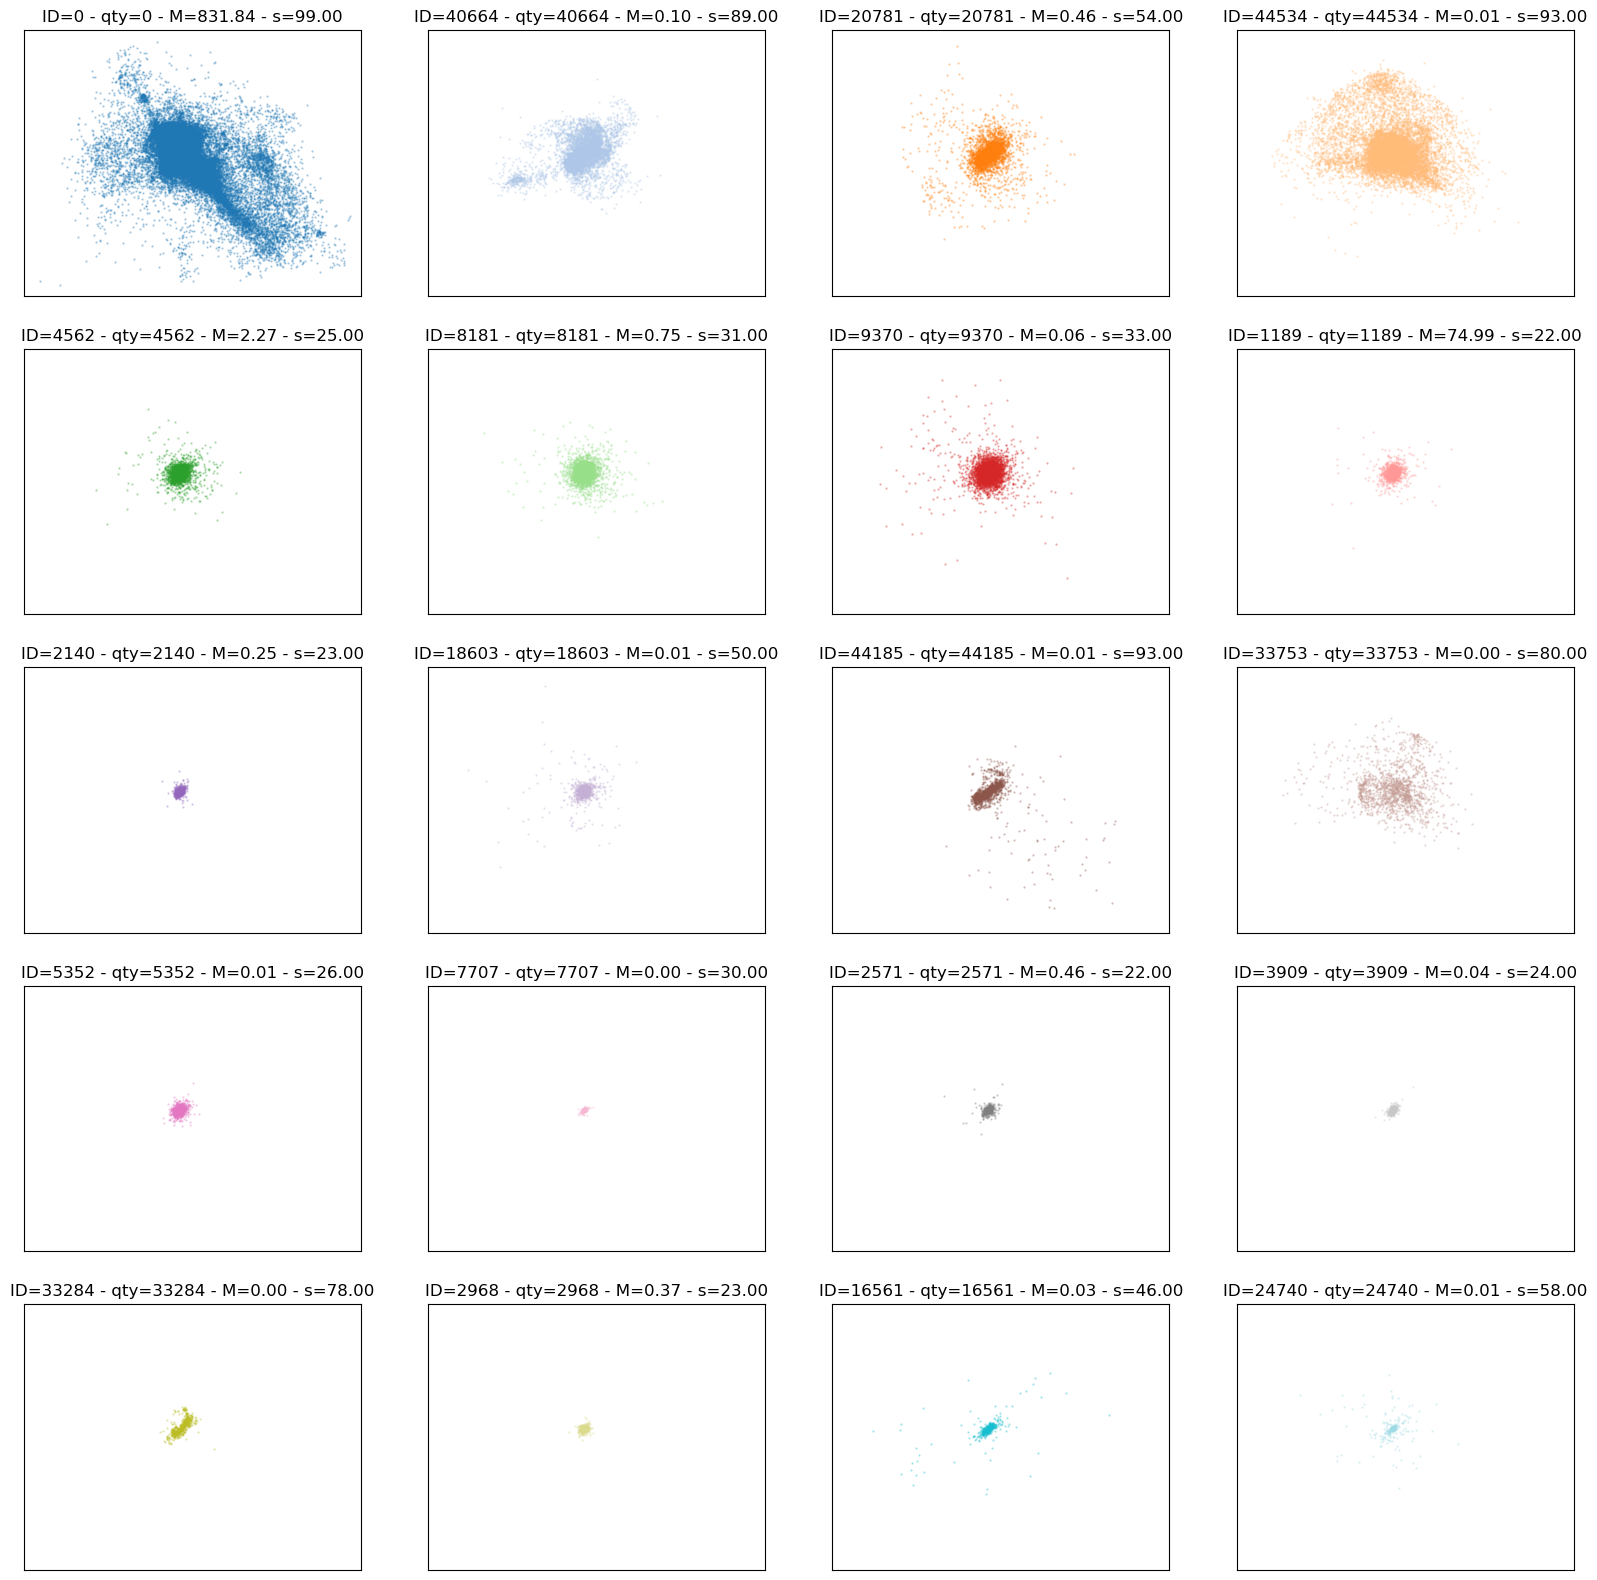

In [9]:
arg_top20_subhalo_most_stars = np.argsort(qty_stars_in_mask)[-20:][::-1]
tree_IDs_subhalo_most_stars = np.array(mask_tree_ID)[arg_top20_subhalo_most_stars]

subhalo_mass = tree['Mass']
snap = tree['SnapNum']

X = stars_coord[:,0]
Y = stars_coord[:,1]

tab20 = plt.cm.get_cmap('tab20', 20).colors
plt.figure(figsize=(20,20))
for index, i in enumerate(tree_IDs_subhalo_most_stars):
    plt.subplot(5,4,index+1)
    arg_use = np.where(next_to_main_stars_ID == i)
    X_use = X[arg_use]
    Y_use = Y[arg_use]
    plt.scatter(X_use,Y_use, s=0.5, alpha=0.3, c=tab20[index])
    # plt.hist2d(X_use,Y_use, bins=100, norm=SymLogNorm(1))
    plt.title(f'ID={i} - qty={tree_IDs_subhalo_most_stars[index]} - M={subhalo_mass[i]:.2f} - s={snap[i]:.2f}')
    plt.xlim([10300,11300])
    plt.ylim([36900,37600])
    plt.xticks([])
    plt.yticks([])
# plt.legend(loc='best')

/tmp/ipykernel_5835/340155528.py:1: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X,Y, s=0.5, alpha=0.3, c=tab20[index])


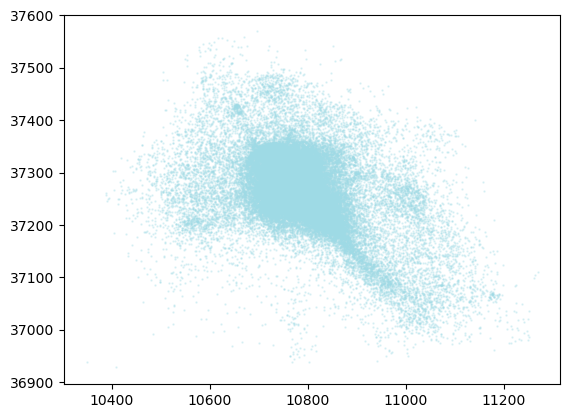

In [10]:
plt.scatter(X,Y, s=0.5, alpha=0.3, c=tab20[index])

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

x_limits = (10000,14000)
y_limits = (37000,38500)

# Set up the figure and axis
fig, ax = plt.subplots()

# # Data for star distrubtion birth at z=0 - replace this with your own data generation
# arg_main = np.where(next_to_main_stars_ID == 0)
# num_frames = len(np.unique(stars_ID[arg_main]))
# def generate_data(frame_number):
#     # This function should generate your image data

#     arg_main = np.where(next_to_main_stars_ID == 0)

#     i = np.unique(stars_ID[arg_main])[frame_number]
#     arg_use = np.where(stars_ID[arg_main] <= i)
#     X_use = X[arg_main][arg_use]
#     Y_use = Y[arg_main][arg_use]

#     return np.array([X_use,Y_use])

# # Data for all stars of main branch through snapshots
# main_SubfindID = tree_main['SubfindID']
# snap = tree_main['SnapNum'][::-1]
# num_frames = len(snap)
# def generate_data(frame_number):
    
#     stars_coord  = il.snapshot.loadSubhalo(basePath,snap[frame_number], main_SubfindID[::-1][frame_number], 'stars', fields=['Coordinates', 'ParticleIDs'])
#     if stars_coord['count'] == 0:
#         return np.array([[],[]])
#     else:
#         X = stars_coord['Coordinates'][:,0]
#         Y = stars_coord['Coordinates'][:,1]

#     return np.array([X,Y])

# Data for only in situ stars of main branch through snapshots
main_SubfindID = tree_main['SubfindID']
snap = tree_main['SnapNum'][::-1]
num_frames = len(snap)

stars  = il.snapshot.loadSubhalo(basePath,99, tree_main['SubfindID'][::-1][-1], 'stars', fields=['Coordinates','ParticleIDs'])
stars_ParticleIDs = stars['ParticleIDs']
# rm_previous_snap = np.ones_like(stars_ParticleIDs)
def generate_data(frame_number):

    arg_insitu = np.where(next_to_main_stars_ID == 0)[0]
    arg_exsitu = np.where(next_to_main_stars_ID != 0)[0]

    # # i = np.unique(stars_ID[arg_main])[frame_number]
    # arg_insitu_use = np.where(stars_ID[arg_insitu] <= frame_number)
    # arg_exsitu_use = np.where(stars_ID[arg_exsitu] <= frame_number)

    ParticleIDs_insitu = stars_ParticleIDs[arg_insitu]#[arg_insitu_use]
    ParticleIDs_exsitu = stars_ParticleIDs[arg_exsitu]#[arg_exsitu_use]
    
    stars_coord  = il.snapshot.loadSubhalo(basePath,snap[frame_number], main_SubfindID[::-1][frame_number], 'stars', fields=['Coordinates', 'ParticleIDs'])


    if stars_coord['count'] == 0:
        return np.array([[],[]]), np.array([[],[]])
    else:
        here_stars_ParticleIDs = stars_coord['ParticleIDs']
        mask_insitu = np.isin(here_stars_ParticleIDs, ParticleIDs_insitu)
        mask_exsitu = np.isin(here_stars_ParticleIDs, ParticleIDs_exsitu)

        X_insitu = stars_coord['Coordinates'][mask_insitu,0]
        Y_insitu = stars_coord['Coordinates'][mask_insitu,1]

        X_exsitu = stars_coord['Coordinates'][mask_exsitu,0]
        Y_exsitu = stars_coord['Coordinates'][mask_exsitu,1]

        # rm_previous_snap[np.isin(ParticleIDs_insitu,here_stars_ParticleIDs)] = 0

    return np.array([X_insitu,Y_insitu]),  np.array([X_exsitu,Y_exsitu])

# Update function for animation
def update(frame_number):
    data1, data2 = generate_data(frame_number)
    ax.clear()
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_title('All stars in main branch')
    ax.set_xlabel(f's = {frame_number+1}')
    # ax.set_legend(loc='upper right')
    im = ax.scatter(data1[0], data1[1], s=0.5, alpha=0.3, c='blue', animated=True)#, label='In situ')
    im = ax.scatter(data2[0], data2[1], s=0.5, alpha=0.3, c='orange', animated=True)#, label='Ex situ')
    # im = ax.hist2d(data[0], data[1], bins=100, norm=SymLogNorm(1), animated=True)
    return im,

# Create the animation
anim = FuncAnimation(fig, update, frames=num_frames, blit=True)

# Convert the animation to an HTML5 video and display it
animation_html = HTML(anim.to_html5_video())
display(animation_html)

# Close the figure to prevent displaying the final static plot
plt.close(fig)

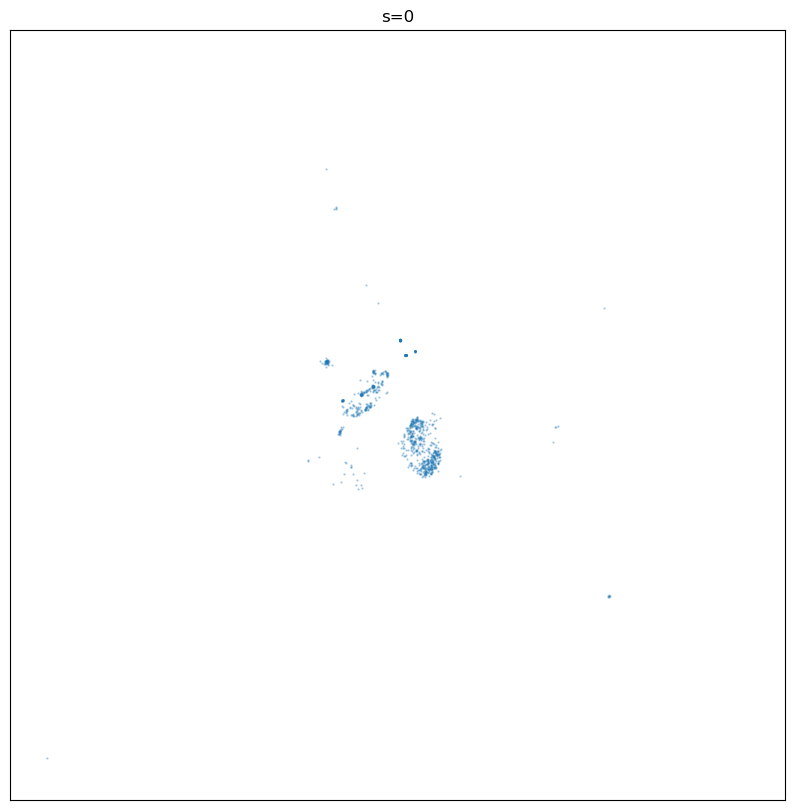

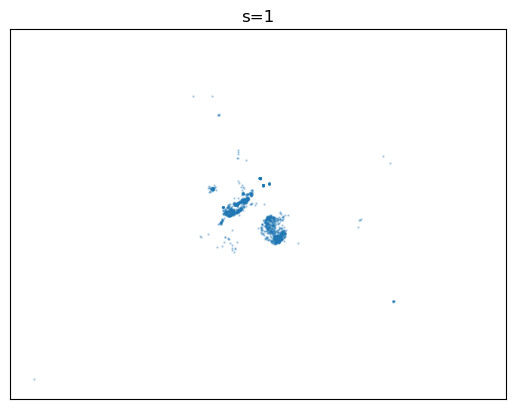

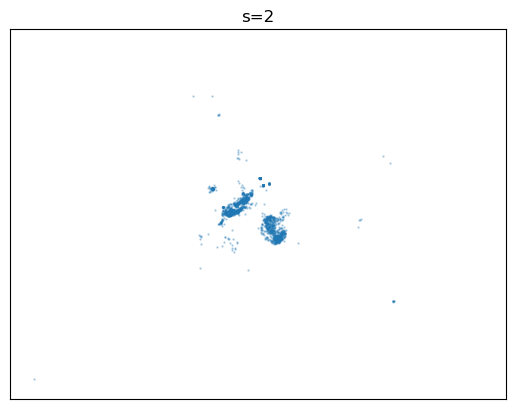

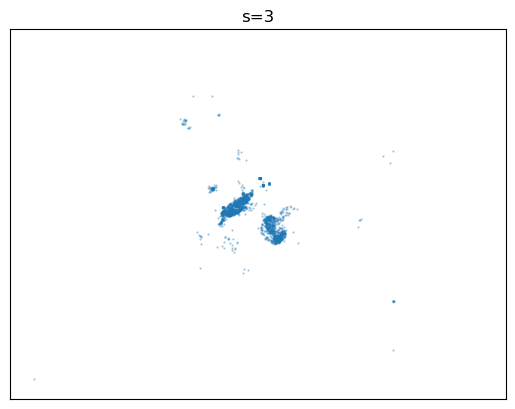

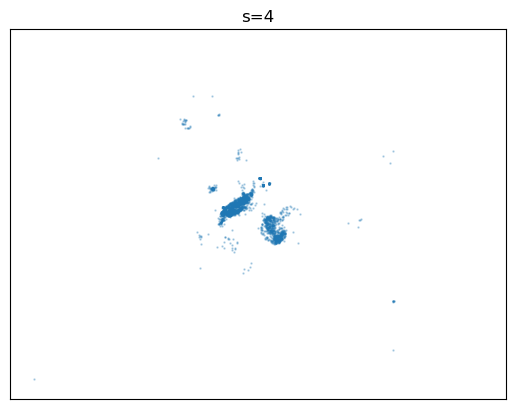

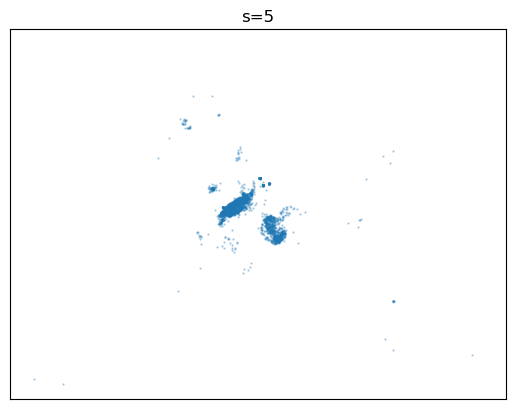

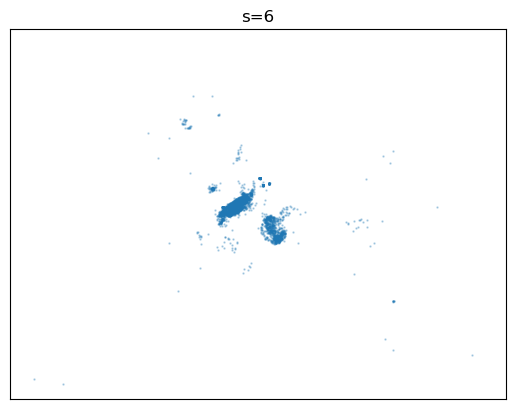

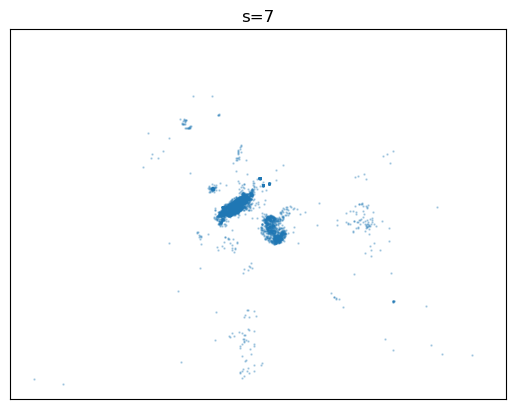

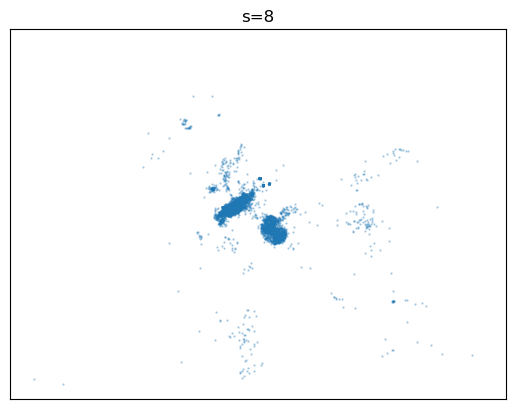

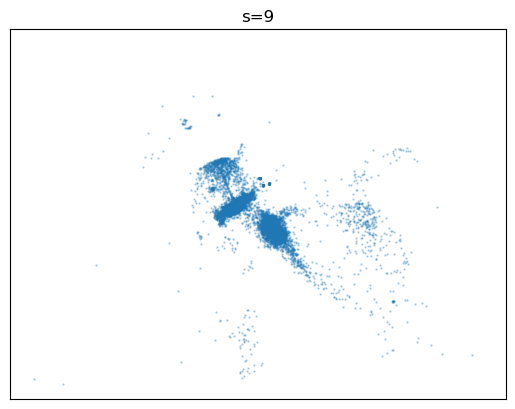

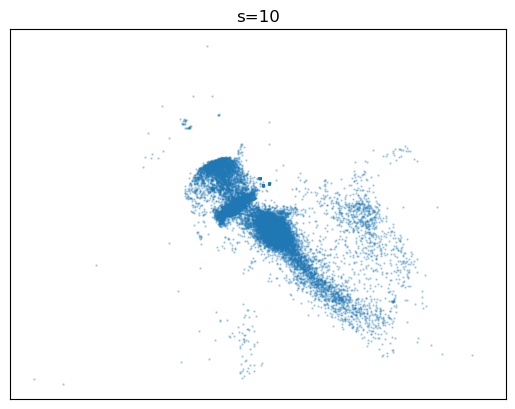

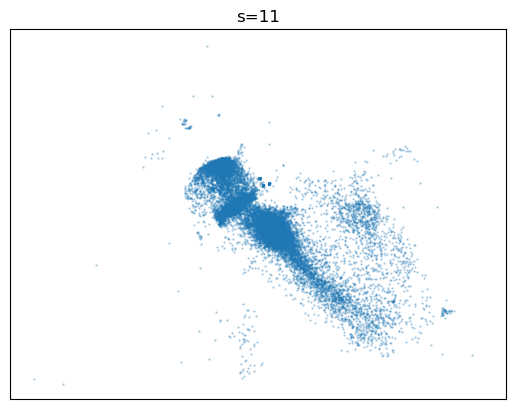

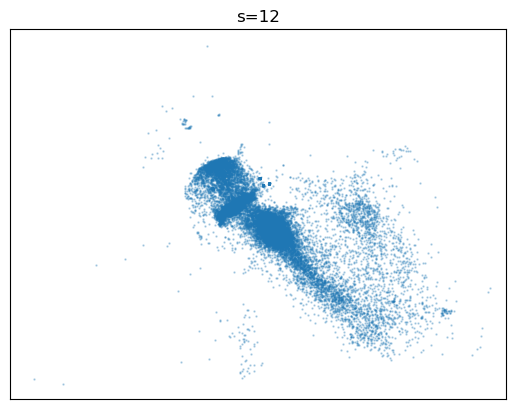

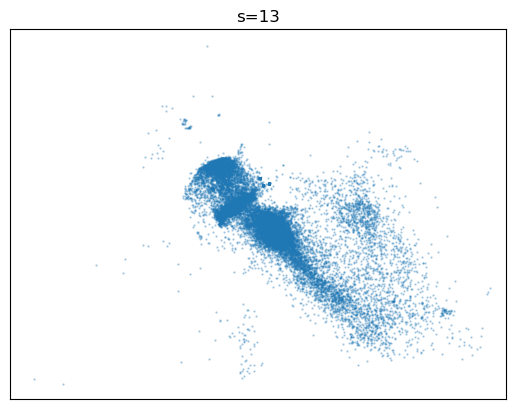

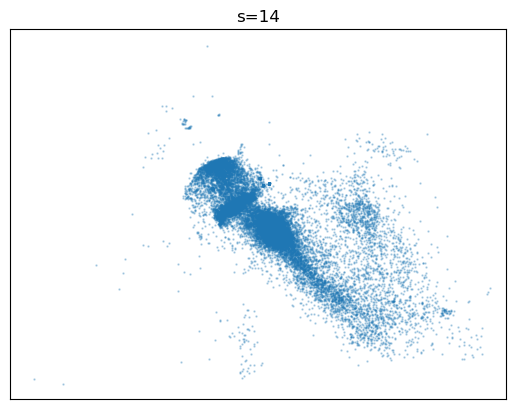

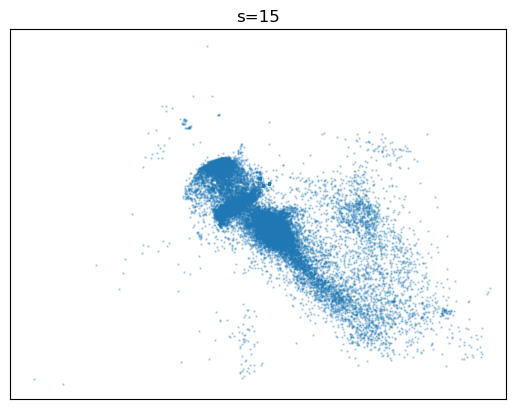

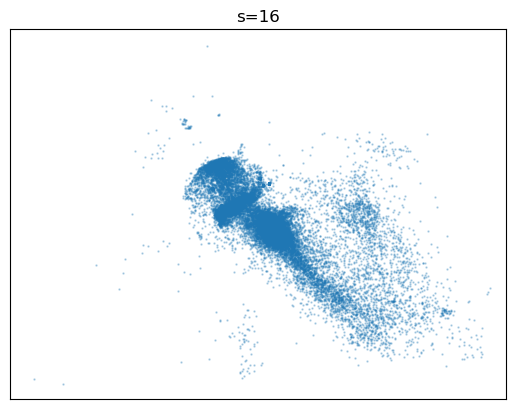

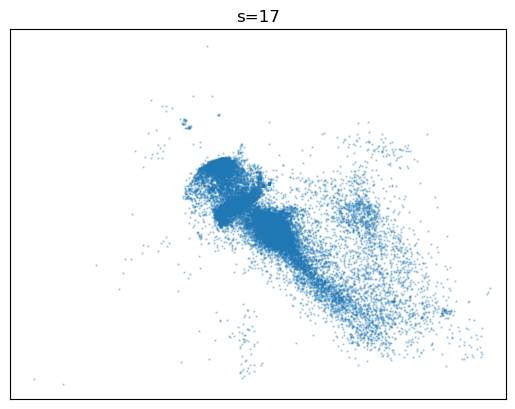

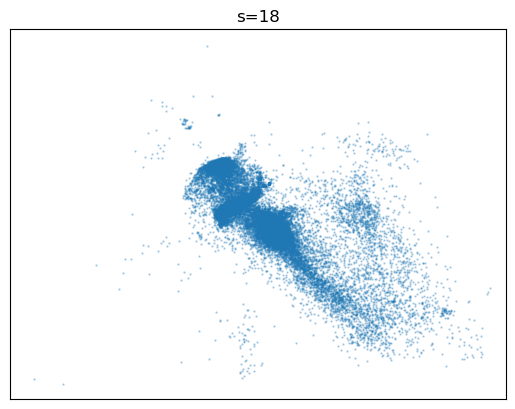

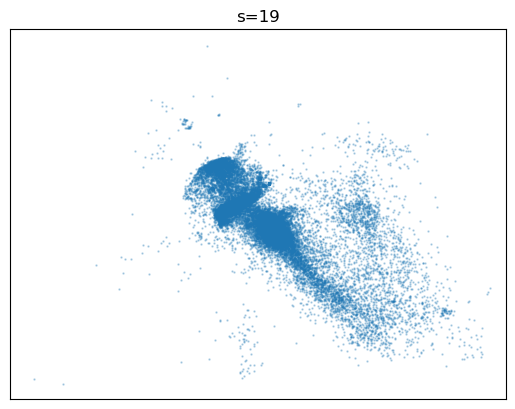

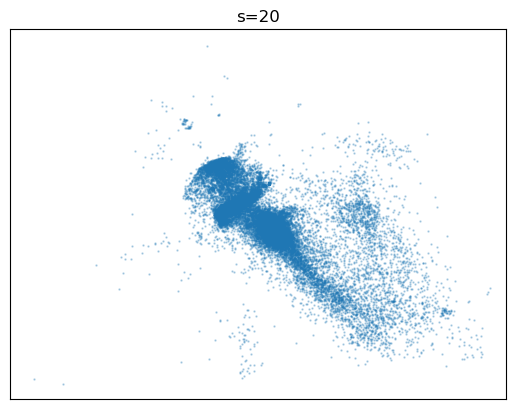

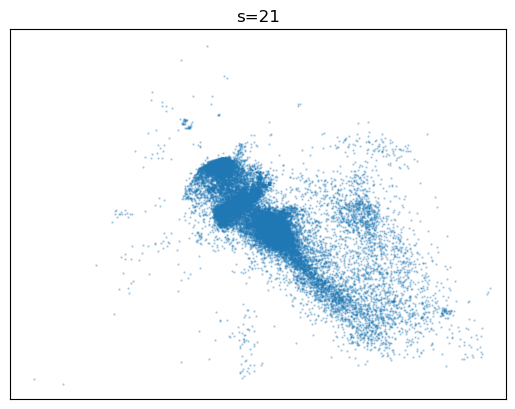

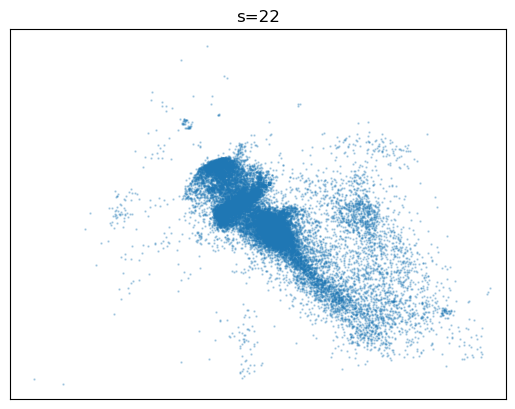

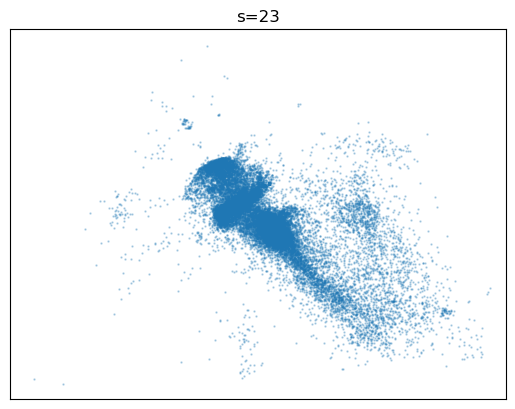

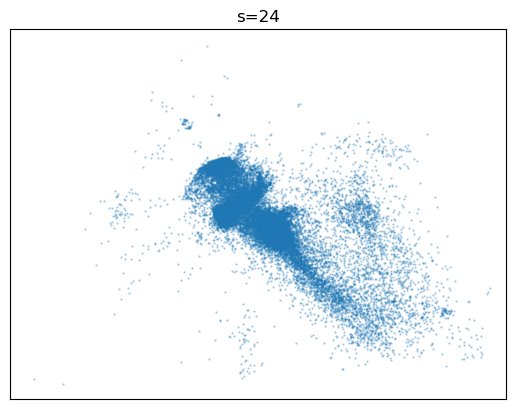

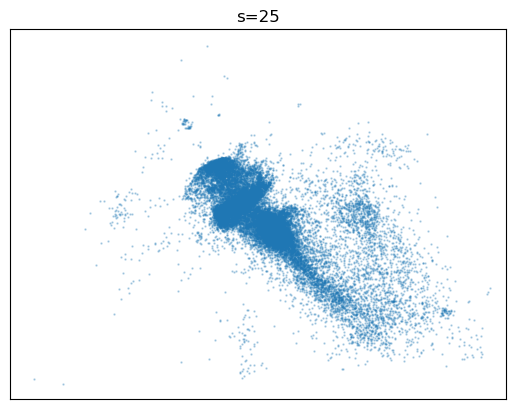

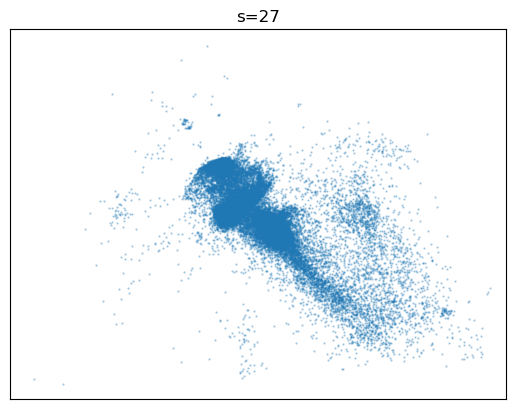

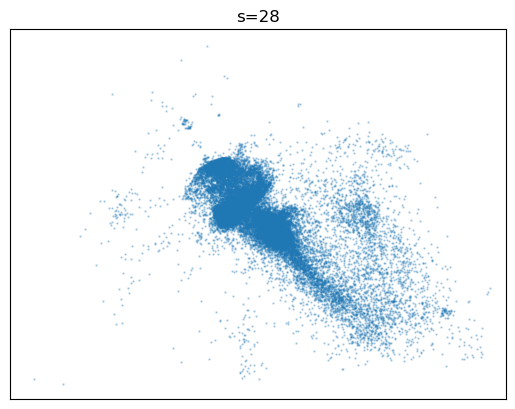

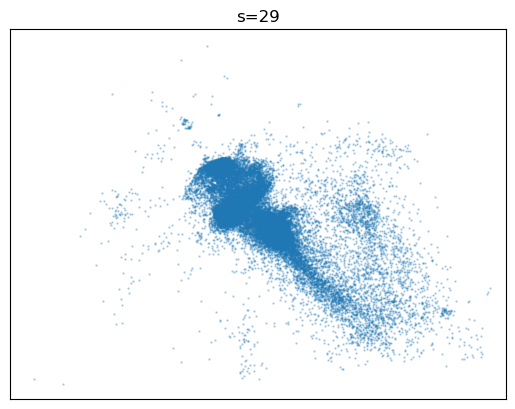

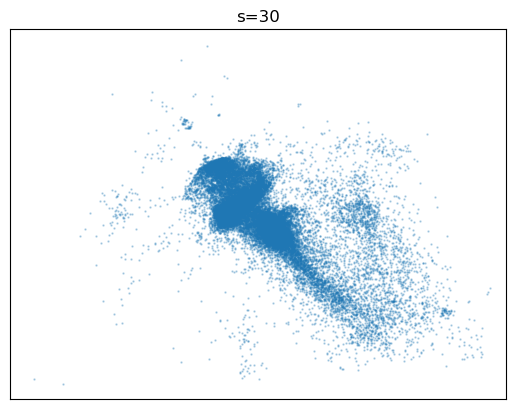

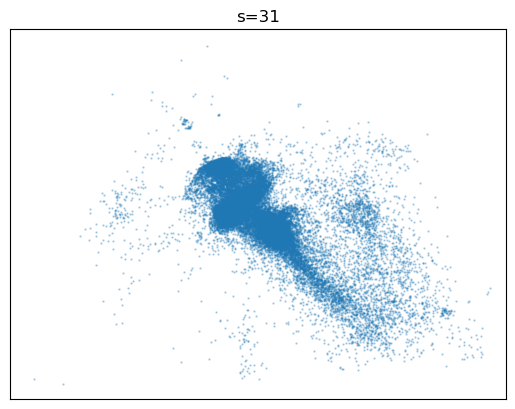

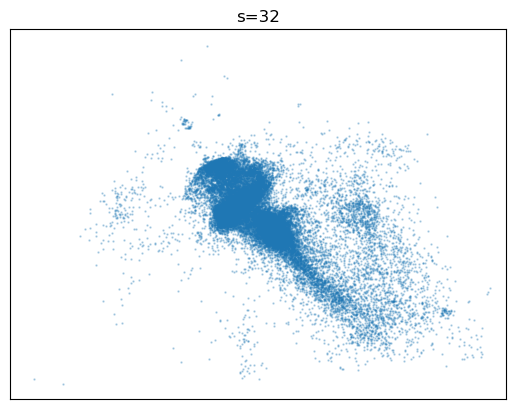

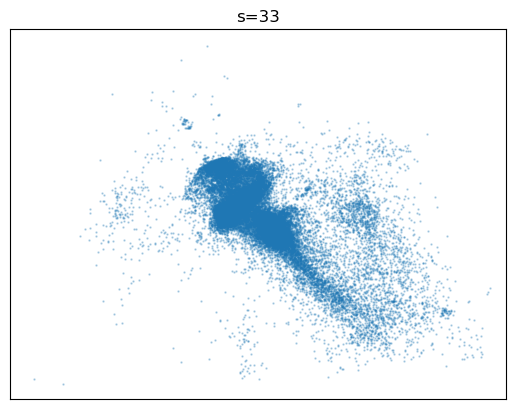

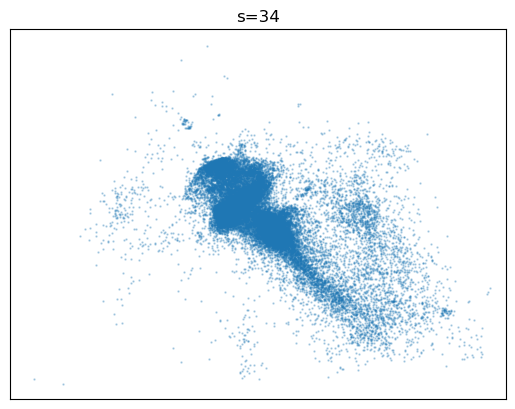

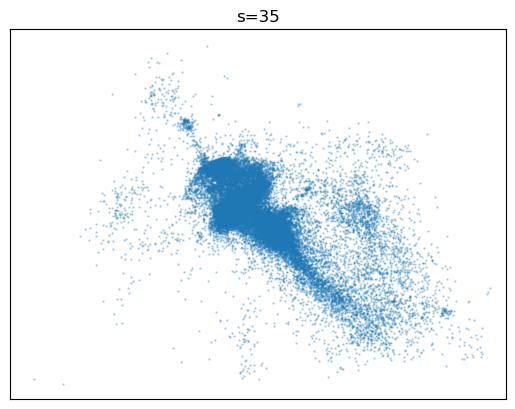

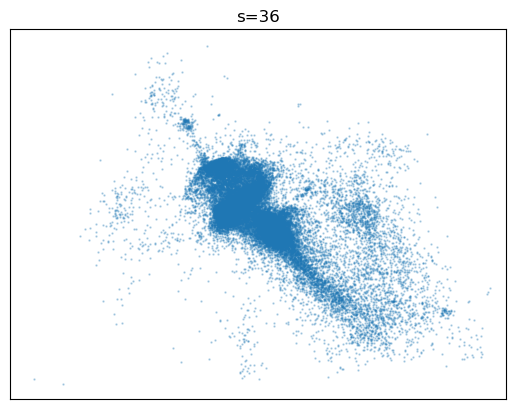

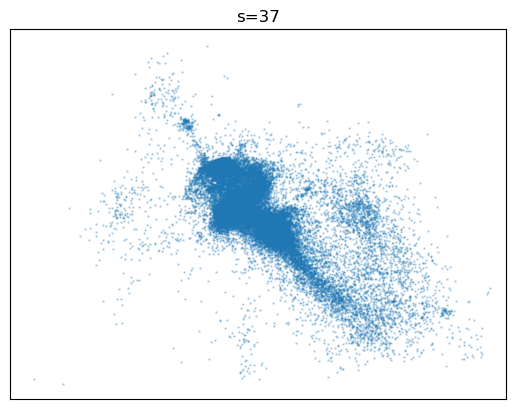

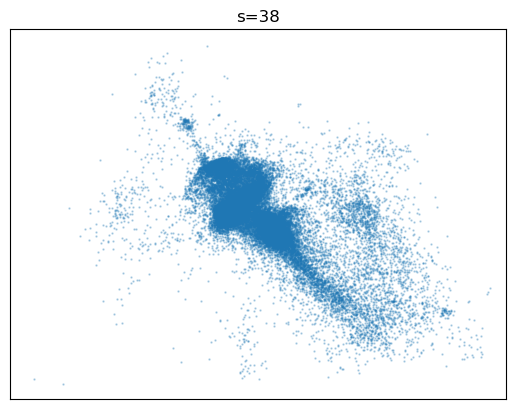

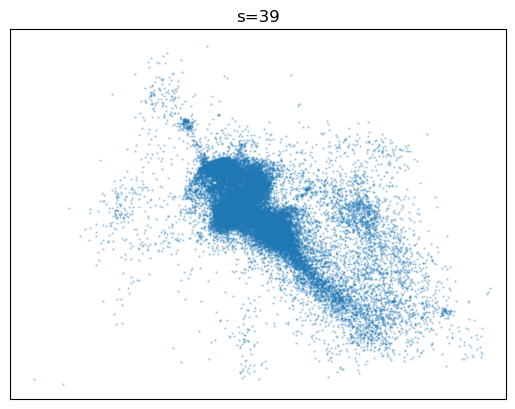

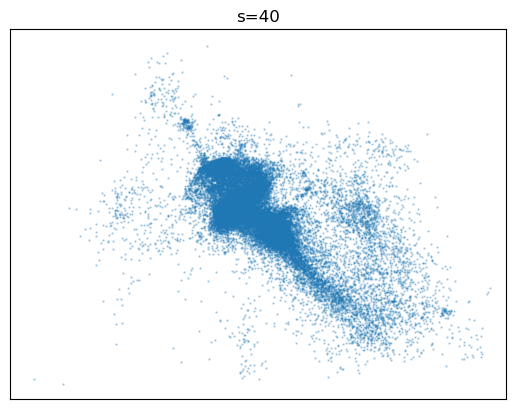

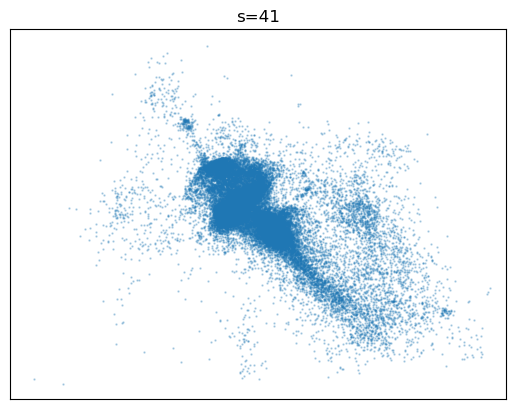

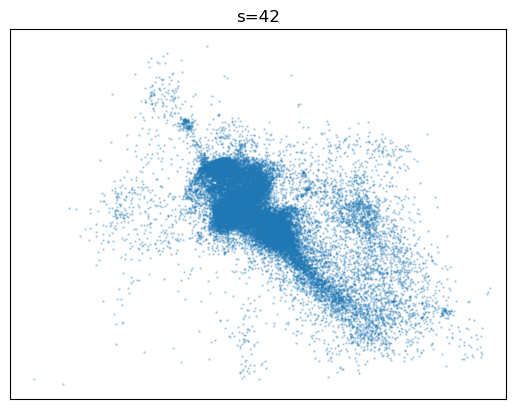

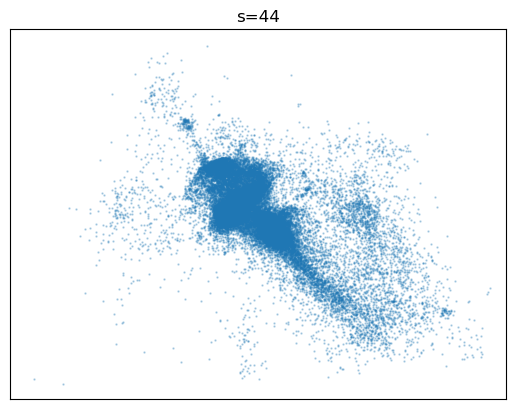

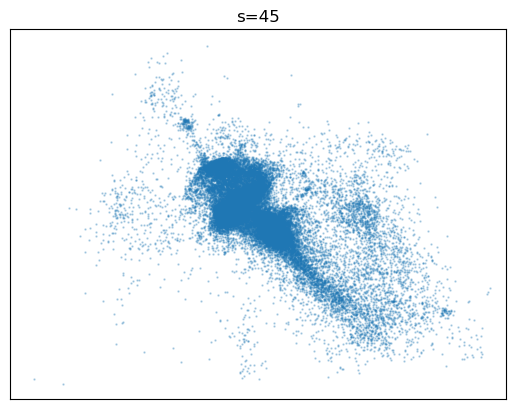

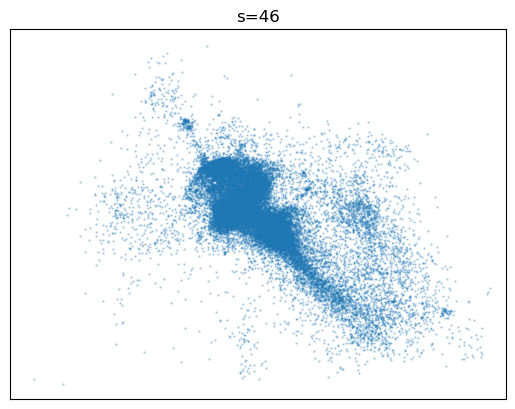

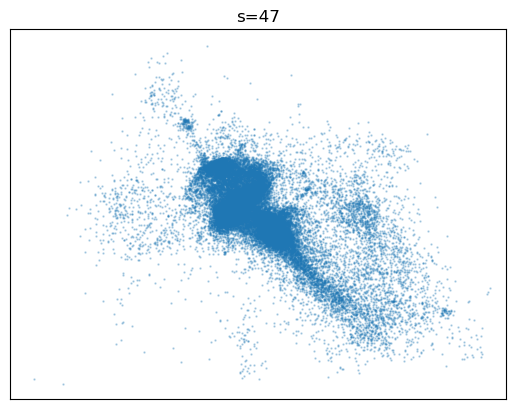

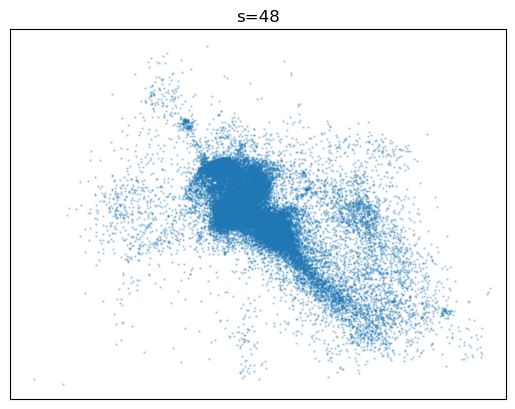

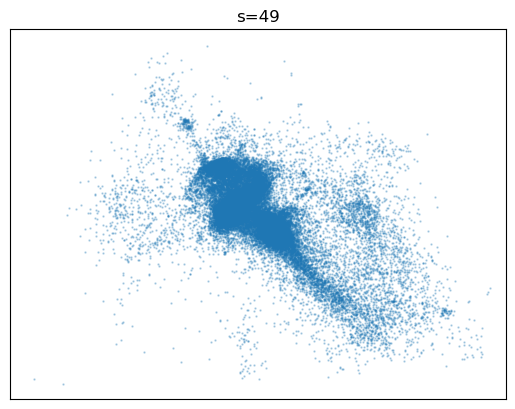

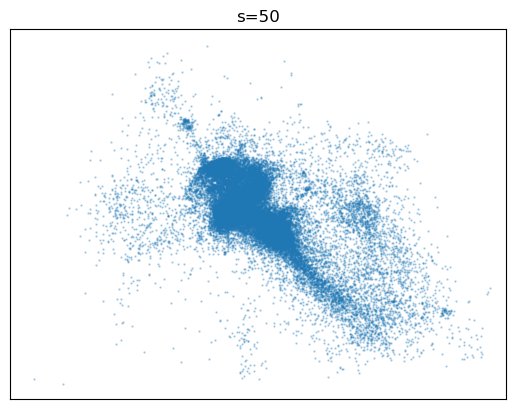

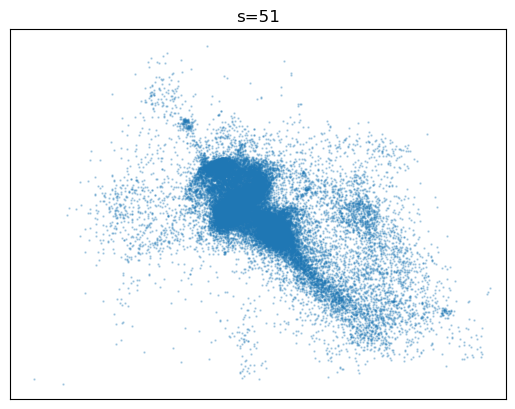

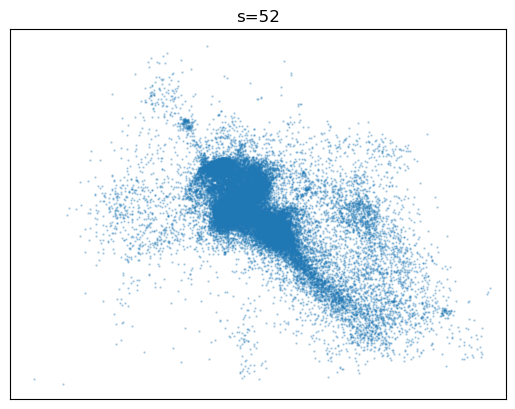

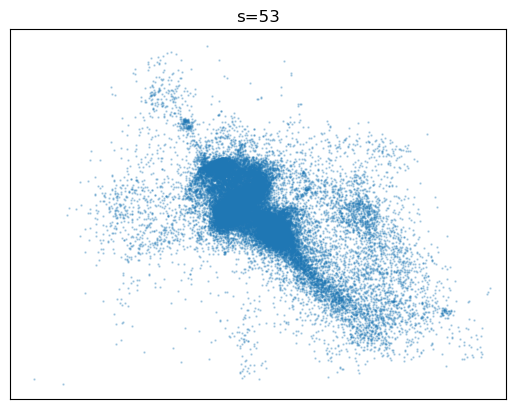

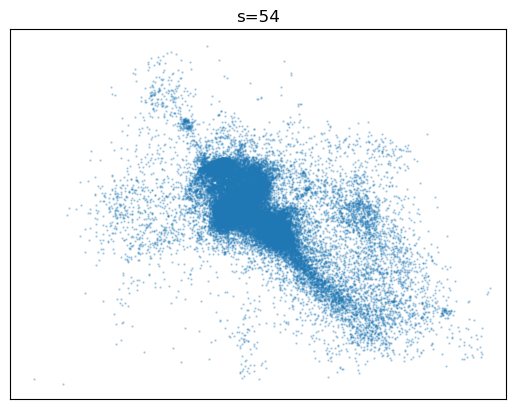

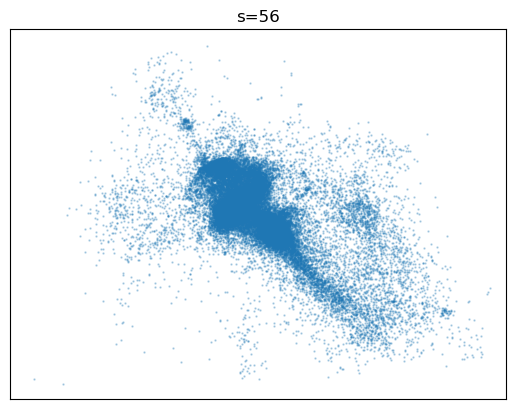

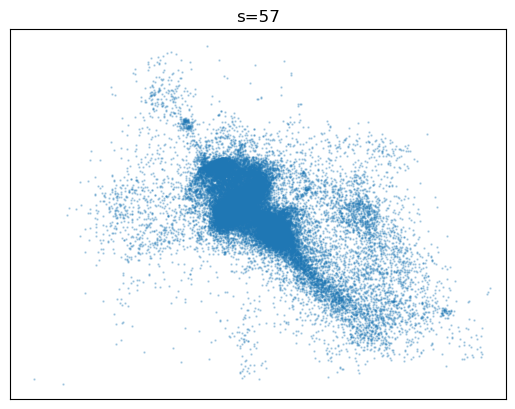

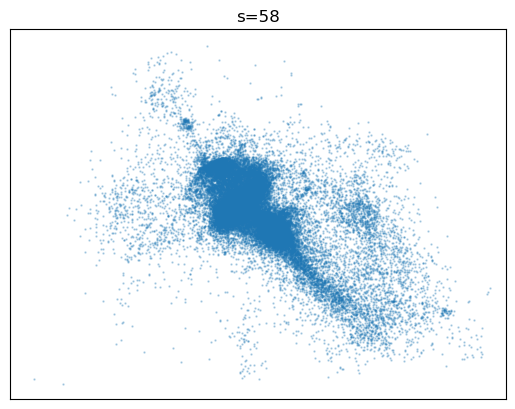

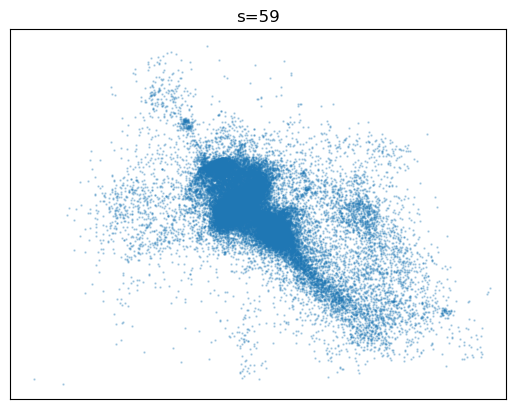

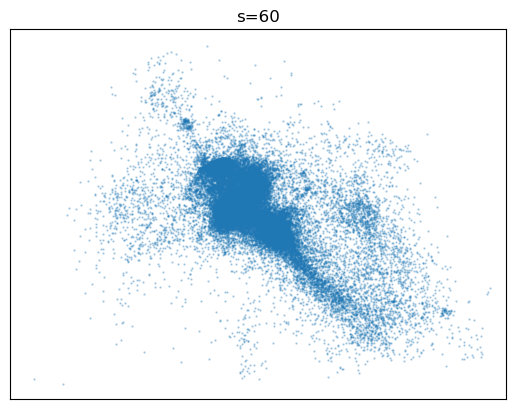

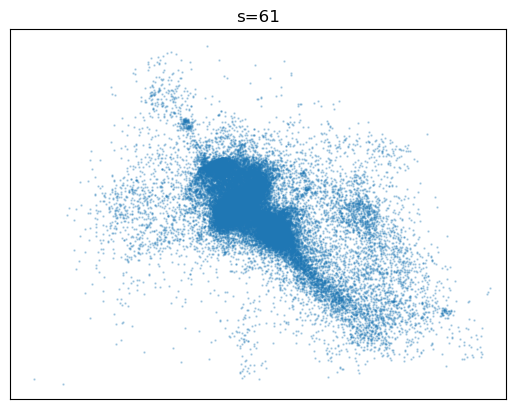

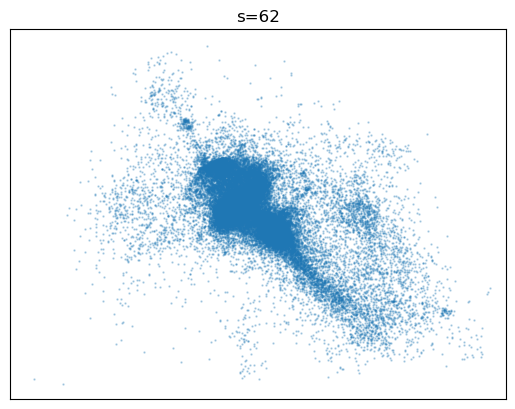

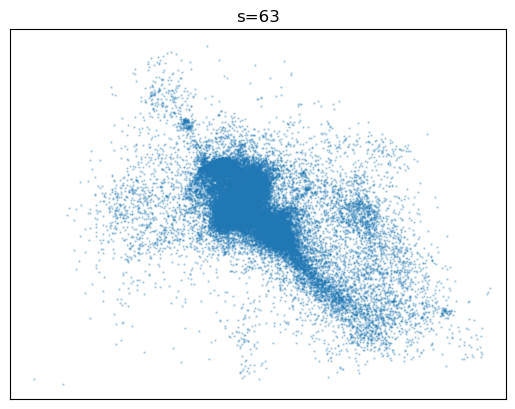

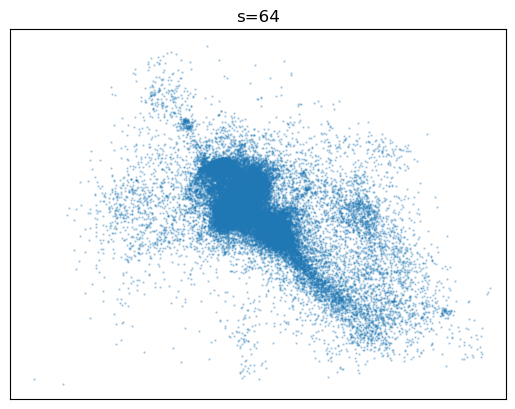

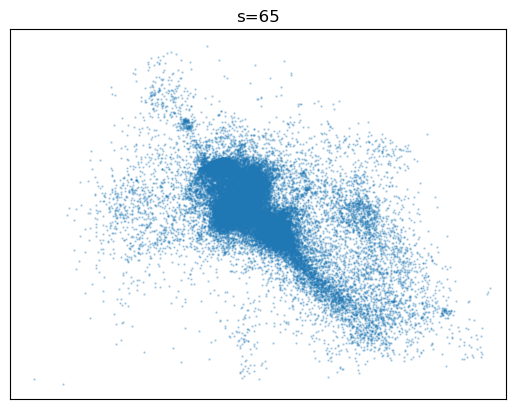

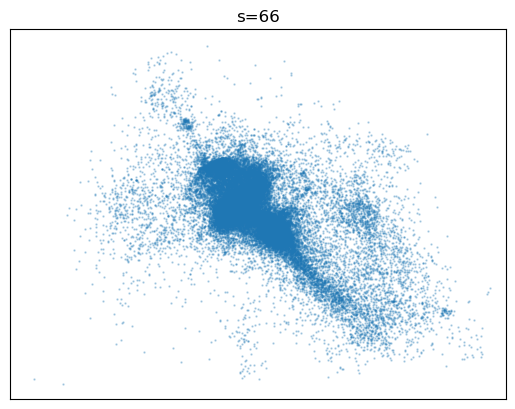

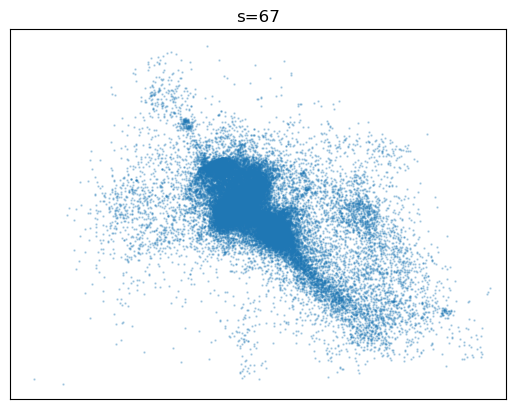

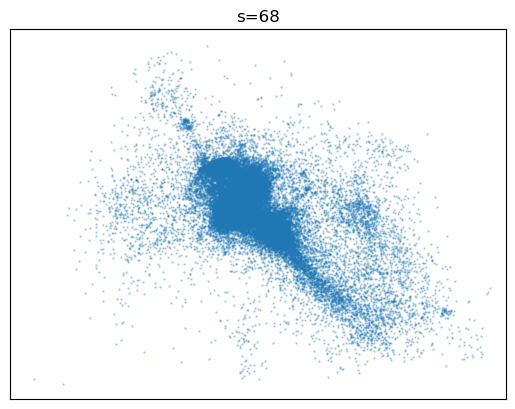

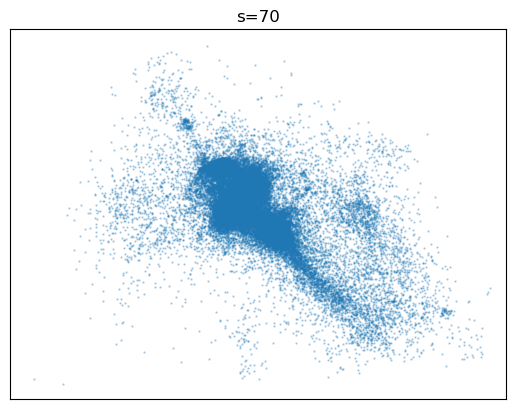

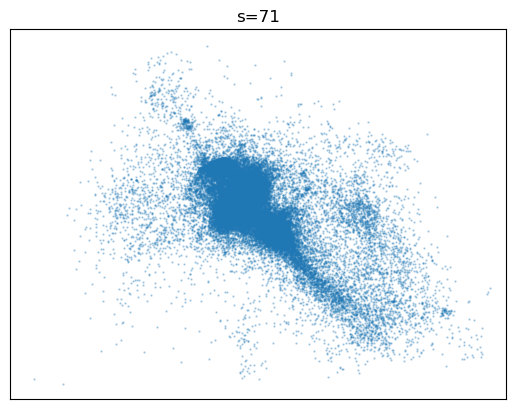

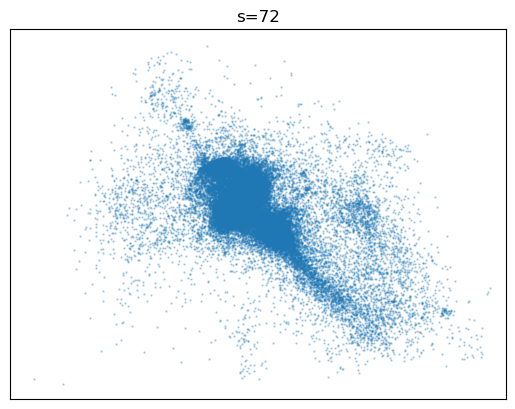

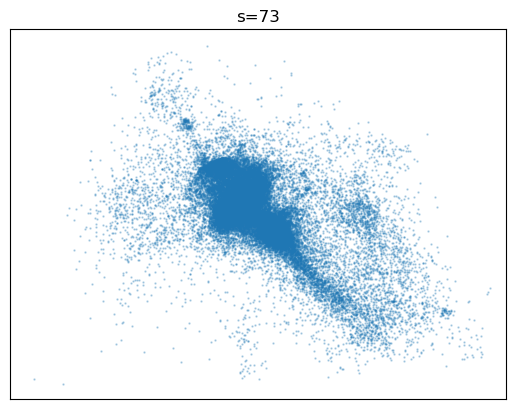

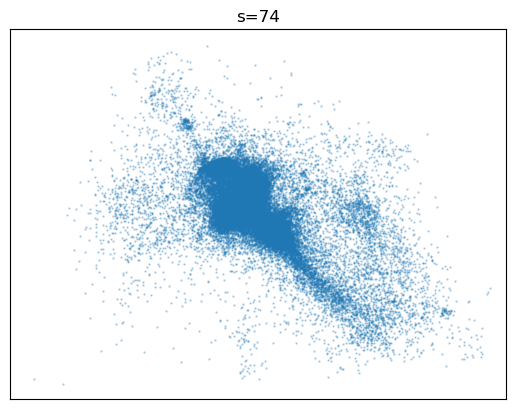

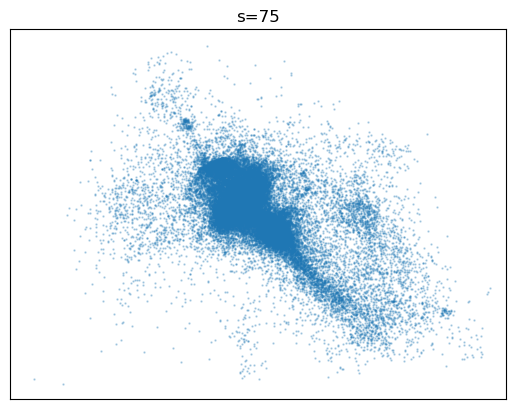

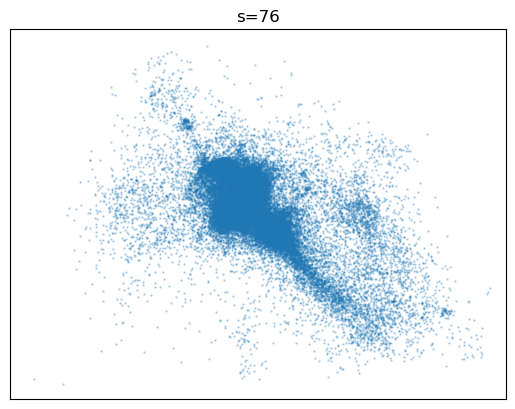

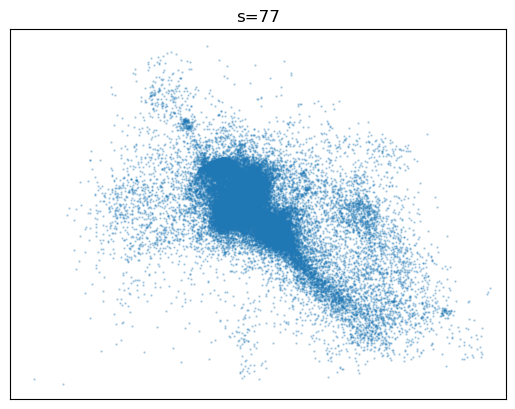

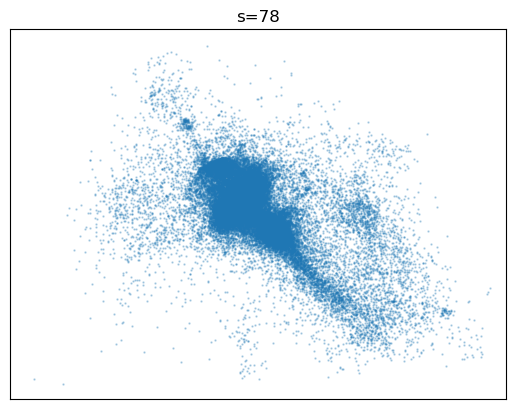

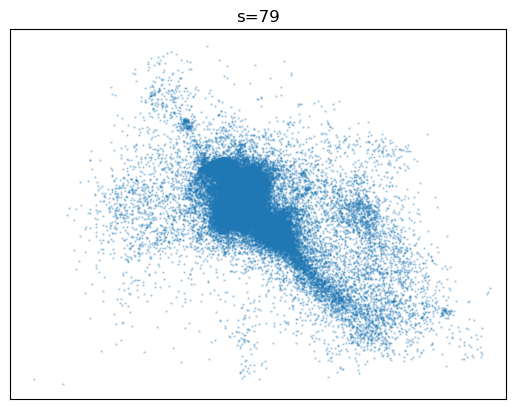

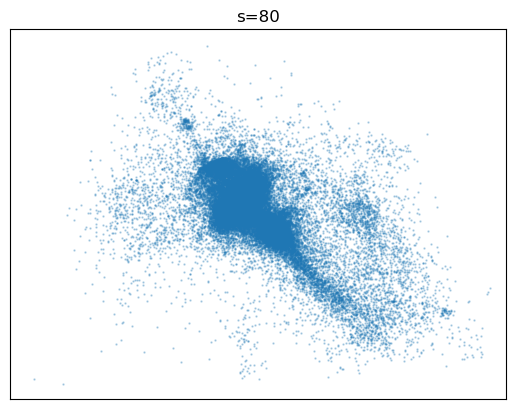

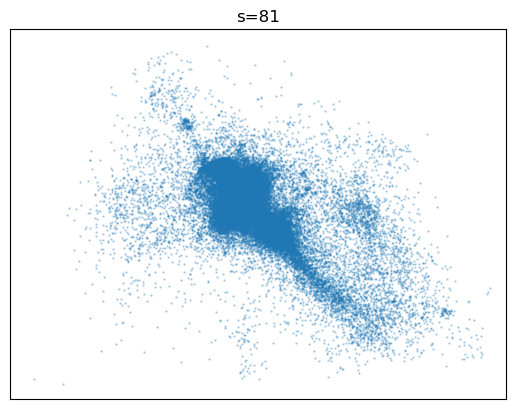

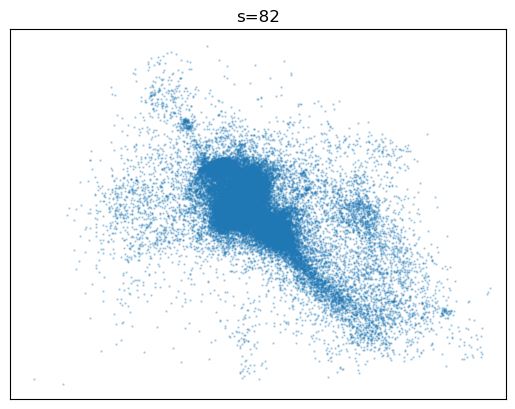

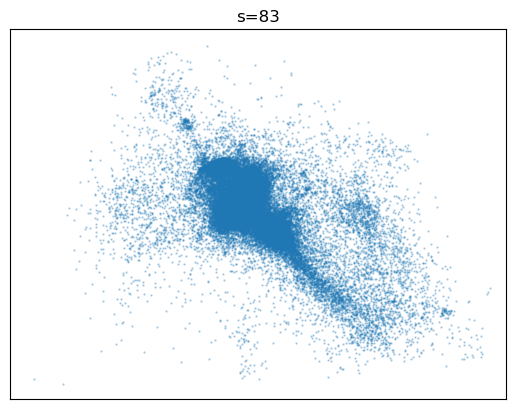

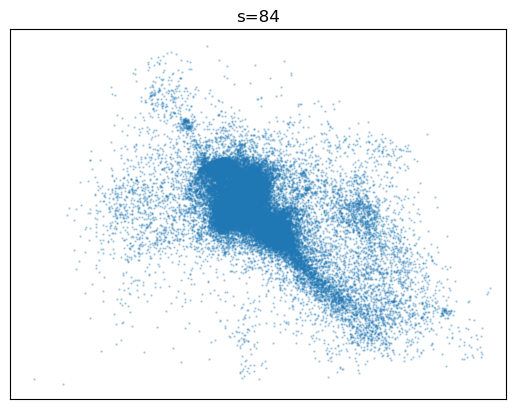

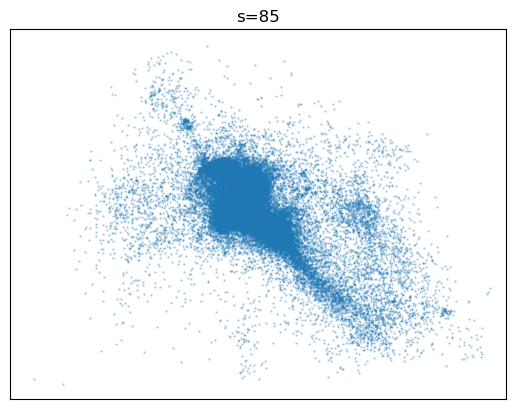

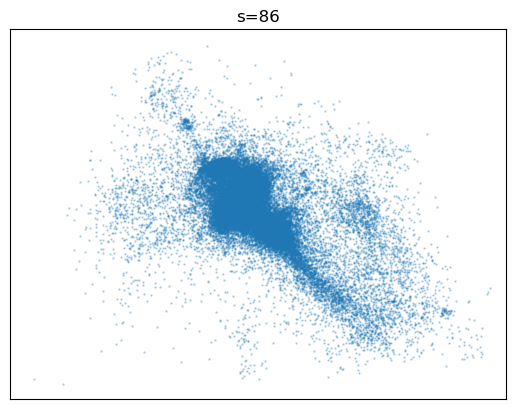

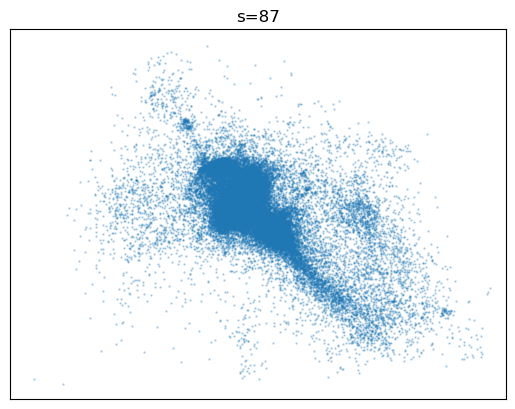

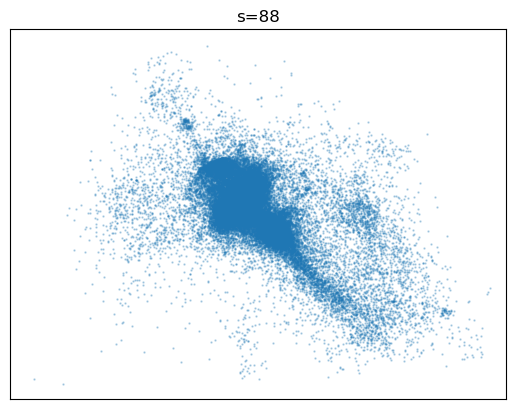

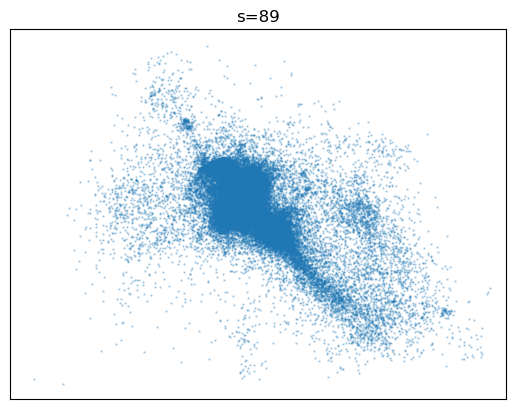

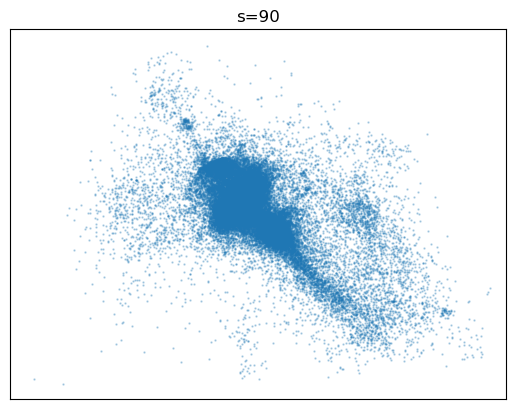

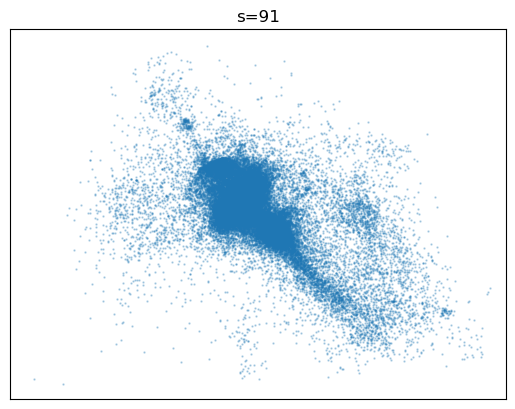

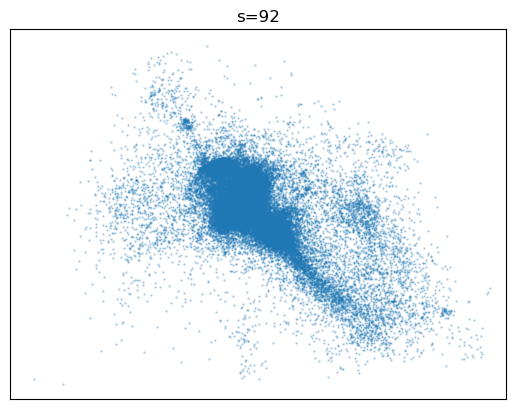

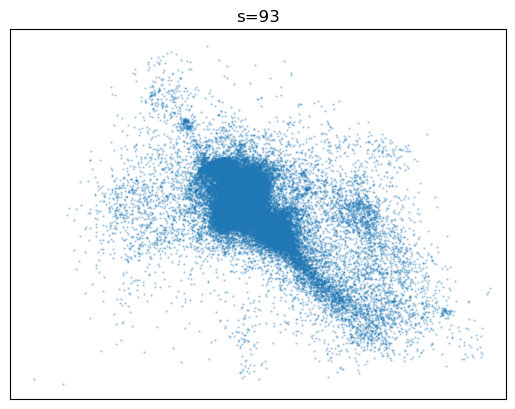

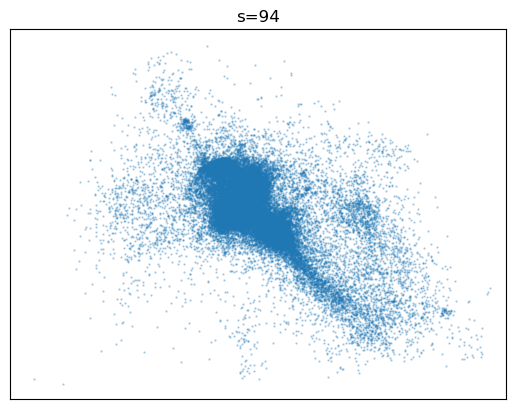

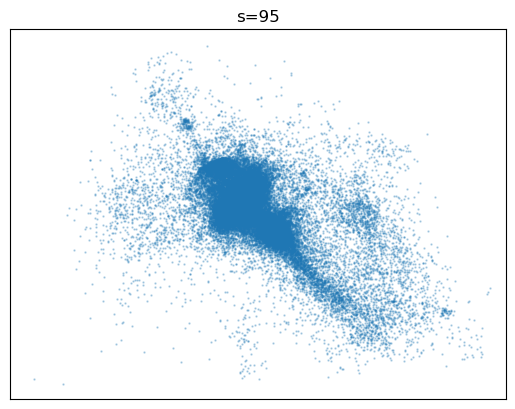

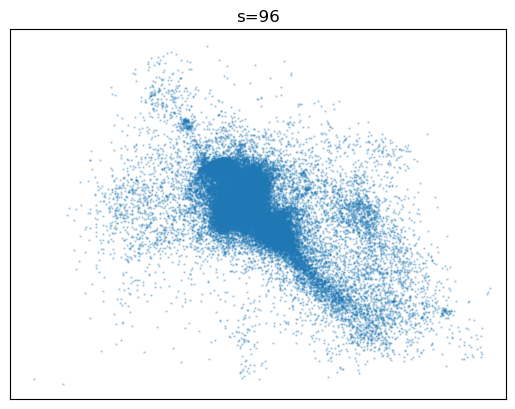

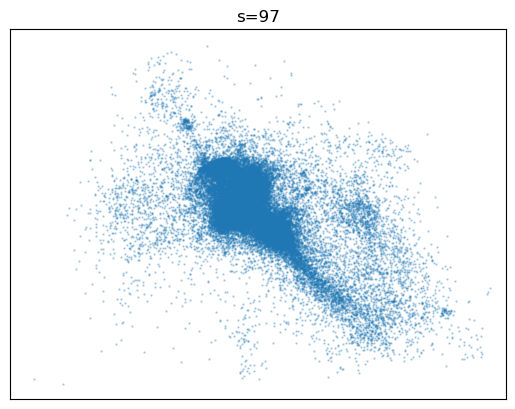

In [216]:
### Plot the main progenitor at very snapshot ###

snapshots = range(99, -1, -1)
main_SubfindID = il.sublink.loadTree(basePath,snap,halo_ID,onlyMPB=True, fields=['SubfindID'])
plt.figure(figsize=(10,10))
for index, i in enumerate(tqdm(snapshots)):
    stars_coord  = il.snapshot.loadSubhalo(basePath,i, main_SubfindID[index], 'stars', fields=['Coordinates', 'ParticleIDs'])
    X = stars_coord[:,0]
    Y = stars_coord[:,1]
    # plt.scatter(X,Y,s=0.5, alpha=0.3)#, c=tab20[index])
    plt.hist2d(X,Y,bins=100,norm=SymLogNorm(1))
    plt.title(f'{i}')
    # plt.title(f'ID={stars_ID_before_main[arg_use][0]} - M={stars_ID_before_main_mass[arg_use][0]:.1f}')
    # plt.xlim([10300,11300])
    # plt.ylim([36900,37600])
    plt.xticks([])
    plt.yticks([])
# plt.legend(loc='best')

In [233]:
range(99)

range(0, 99)